In [1]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing, model_selection
from sklearn.model_selection import KFold, GroupKFold

import lightgbm as lgb

In [2]:
train = pd.read_pickle('./input/train_248.pkl')
test = pd.read_pickle('./input/test_247.pkl')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428932 entries, 0 to 428931
Columns: 248 entries, stock_id to size_tau2_6c1
dtypes: float32(146), float64(95), int32(4), int64(2), object(1)
memory usage: 569.4+ MB


In [4]:
print(len(train.columns))
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

248


244

## LGB
GroupKFold: CV split by time_id

In [5]:
seed0=2021
params0 = {
    'objective': 'rmse',  # 自定义
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],  # stock_id
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
#     'device':'gpu',
    'verbose': -1}

seed111=2021
params_ob_1 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05, 
    'max_bin':100,
'bagging_fraction': 0.710974226064542,
  'bagging_freq': 13,
  'feature_fraction': 0.4749012336999975,
  'lambda_l1': 0.822044301610394,
  'lambda_l2': 9.0357915742179,
  'max_depth': 16,
  'min_data_in_leaf': 1082,
  'min_gain_to_split': 0.05742547426830687,
  'min_sum_hessian_in_leaf': 21.077484016904958,
  'num_leaves': 447,
    
    'categorical_column':[0],
    'seed':seed111,
    'feature_fraction_seed': seed111,
    'bagging_seed': seed111,
    'drop_seed': seed111,
    'data_random_seed': seed111,
    'n_jobs':-1,
#     'device':'gpu',
    'verbose': -1}

seed11=2020
params_ob_2 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05, 
    'max_bin':100,
'bagging_fraction': 0.710974226064542,
  'bagging_freq': 13,
  'feature_fraction': 0.4749012336999975,
  'lambda_l1': 0.822044301610394,
  'lambda_l2': 9.0357915742179,
  'max_depth': 16,
  'min_data_in_leaf': 1082,
  'min_gain_to_split': 0.05742547426830687,
  'min_sum_hessian_in_leaf': 21.077484016904958,
  'num_leaves': 447,
    
    # 'categorical_column':[0],
    'seed':seed11,
    'feature_fraction_seed': seed11,
    'bagging_seed': seed11,
    'drop_seed': seed11,
    'data_random_seed': seed11,
    'n_jobs':-1,
#     'device':'gpu',
    'verbose': -1}

Training fold 1
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.000396878	training's RMSPE: 0.18384	valid_1's rmse: 0.000471689	valid_1's RMSPE: 0.21754
[400]	training's rmse: 0.000371468	training's RMSPE: 0.17207	valid_1's rmse: 0.000470868	valid_1's RMSPE: 0.217162
Early stopping, best iteration is:
[312]	training's rmse: 0.000380594	training's RMSPE: 0.176297	valid_1's rmse: 0.000470697	valid_1's RMSPE: 0.217083
Training fold 2
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.000396359	training's RMSPE: 0.18307	valid_1's rmse: 0.000492083	valid_1's RMSPE: 0.229572
[400]	training's rmse: 0.000370509	training's RMSPE: 0.17113	valid_1's rmse: 0.000490865	valid_1's RMSPE: 0.229003
Early stopping, best iteration is:
[377]	training's rmse: 0.000372544	training's RMSPE: 0.17207	valid_1's rmse: 0.000490158	valid_1's RMSPE: 0.228673
Training fold 3
Training until validation scores don't improve for 100 rounds
[200]	

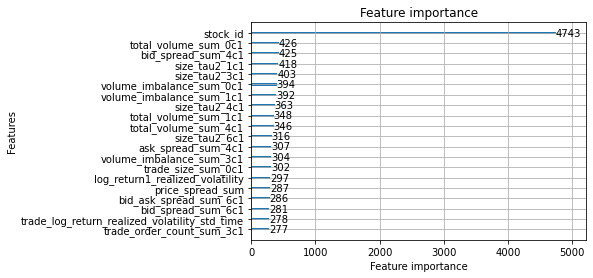

In [6]:
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    
    
    group = train['time_id']
    kfold = GroupKFold(n_splits=5)
    # kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, groups=group)):
#     for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round = 10000,  # 1000
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 200,
                          early_stopping_rounds=100, # 50
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions, oof_predictions
# Traing and evaluate
test_pred_lgb1, valid_pred_lgb1 = train_and_evaluate_lgb(train, test, params_ob_1)

Training fold 1
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.000401805	training's RMSPE: 0.186123	valid_1's rmse: 0.000471594	valid_1's RMSPE: 0.217497
[400]	training's rmse: 0.000378304	training's RMSPE: 0.175236	valid_1's rmse: 0.000468756	valid_1's RMSPE: 0.216188
Early stopping, best iteration is:
[402]	training's rmse: 0.000378152	training's RMSPE: 0.175166	valid_1's rmse: 0.000468719	valid_1's RMSPE: 0.216171
Training fold 2
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.000400984	training's RMSPE: 0.185206	valid_1's rmse: 0.000499464	valid_1's RMSPE: 0.233015
[400]	training's rmse: 0.000377273	training's RMSPE: 0.174254	valid_1's rmse: 0.000498499	valid_1's RMSPE: 0.232565
Early stopping, best iteration is:
[341]	training's rmse: 0.000382417	training's RMSPE: 0.17663	valid_1's rmse: 0.000497713	valid_1's RMSPE: 0.232198
Training fold 3
Training until validation scores don't improve for 100 rounds
[

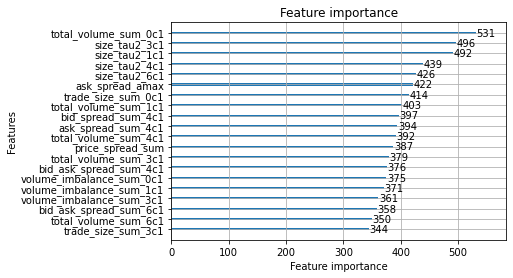

In [7]:
# drop_stock_id, new params

def train_and_evaluate_lgb_2(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"stock_id", "time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    
    
    group = train['time_id']
    kfold = GroupKFold(n_splits=5)
    # kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, groups=group)):
#     for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round = 10000,  # 1000
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 200,
                          early_stopping_rounds=100, # 50
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions, oof_predictions
test_pred_lgb2, valid_pred_lgb2 = train_and_evaluate_lgb_2(train, test, params_ob_2)

In [8]:
# valid
pd.Series(valid_pred_lgb1).to_csv('outputs/valid_pred_lgb1.csv',index=0)
pd.Series(valid_pred_lgb2).to_csv('outputs/valid_pred_lgb2.csv',index=0)
# test
pd.Series(test_pred_lgb1).to_csv('outputs/test_pred_lgb1.csv',index=0)
pd.Series(test_pred_lgb2).to_csv('outputs/test_pred_lgb2.csv',index=0)